# Neuromatch Academy 2020 -- Week 3 Day 3 Tutorial 3
# Causality Day - Simultaneous fitting/regression

**Content creators**: Ari Benjamin, Tony Liu, Konrad Kording

**Content reviewers**: Mike X Cohen, Madineh Sarvestani, Ella Batty, Michael Waskom

---
# Tutorial objectives

This is tutorial 3 on our day of examining causality. Below is the high level outline of what we'll cover today, with the sections we will focus on in this notebook in bold:

1.   Master definitions of causality
2.   Understand that estimating causality is possible
3.   Learn 4 different methods and understand when they fail
    1. perturbations
    2. correlations
    3. **simultaneous fitting/regression**
    4. instrumental variables

### Notebook 3 objectives

In tutorial 2 we explored correlation as an approximation for causation and learned that correlation $\neq$ causation for larger networks. However, computing correlations is a rather simple approach, and you may be wondering: will more sophisticated techniques allow us to better estimate causality? Can't we control for things? 

Here we'll use some common advanced (but controversial) methods that estimate causality from observational data. These methods rely on fitting a function to our data directly, instead of trying to use perturbations or correlations. Since we have the full closed-form equation of our system, we can try these methods and see how well they work in estimating causal connectivity when there are no perturbations. Specifically, we will:

- Learn about more advanced (but also controversial) techniques for estimating causality
    - conditional probabilities (**regression**)
- Explore limitations and failure modes
    - understand the problem of **omitted variable bias**


---
# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso

In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
# @title Helper functions


def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def logit(x):
    """

    Applies the logit (inverse sigmoid) transformation

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))


def create_connectivity(n_neurons, random_state=42, p=0.9):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[p, 1 - p])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def get_regression_estimate_full_connectivity(X):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    reg = MultiOutputRegressor(Lasso(fit_intercept=False,
                                     alpha=0.01, max_iter=250 ), n_jobs=-1)
    reg.fit(W, Y)

    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(reg.estimators_):
        V[i, :] = estimator.coef_

    return V


def get_regression_corr_full_connectivity(n_neurons, A, X, observed_ratio, regression_args):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): number of neurons
        A (np.ndarray): connectivity matrix
        X (np.ndarray): dynamical system
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate_full_connectivity(sel_X)
    return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1,0], sel_V


def see_neurons(A, ax, ratio_observed=1, arrows=True):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    n = len(A)

    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n, endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    if arrows:
      for i in range(n):
          for j in range(n):
              if A[i, j] > 0:
                  ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', head_width=.05,
                          width = A[i, j] / 25,shape='right', length_includes_head=True,
                          alpha = .2)
    if ratio_observed < 1:
      nn = int(n * ratio_observed)
      ax.scatter(x[:nn], y[:nn], c='r', s=150, label='Observed')
      ax.scatter(x[nn:], y[nn:], c='b', s=150, label='Unobserved')
      ax.legend(fontsize=15)
    else:
      ax.scatter(x, y, c='k', s=150)
    ax.axis('off')


def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility

    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)


    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X


def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
        """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:]
  return R


def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0, 1]


def get_regression_corr(n_neurons, A, X, observed_ratio, regression_args, neuron_idx=None):
    """

    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): the number of neurons in our system.
        A (np.array): the true connectivity
        X (np.array): the simulated system
        observed_ratio (float): the proportion of n_neurons observed, must be between 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons * observed_ratio), 1, n_neurons)
    selected_X = X[:sel_idx, :]
    selected_connectivity = A[:sel_idx, :sel_idx]

    estimated_selected_connectivity = get_regression_estimate(selected_X, neuron_idx=neuron_idx)
    if neuron_idx is None:
        return np.corrcoef(selected_connectivity.flatten(),
                           estimated_selected_connectivity.flatten())[1, 0], estimated_selected_connectivity
    else:
        return np.corrcoef(selected_connectivity[neuron_idx, :],
                           estimated_selected_connectivity)[1, 0], estimated_selected_connectivity


def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap

    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")

# Summary of helper functions:

*sigmoid*: 
computing sigmoid nonlinearity element-wise on x.

*logit*:
Applies the logit (inverse sigmoid) transformation log(x/(1-x))

*create_connectivity(n_neurons, random_state=42, p=0.9)*:
Generate our nxn causal connectivity matrix using SVD.

*get_regression_estimate_full_connectivity*: Estimates the connectivity matrix using lasso regression; extract the transpose matrices, apply logit (inverse sigmoid) transformation log(x/(1-x)) and then fit using multioutput regression; 

*get_regression_corr_full_connectivity(n_neurons, A, X, observed_ratio, regression_args)*: A wrapper function for our correlation calculations between A and the V estimated from regression.

*see_neurons(A, ax, ratio_observed=1, arrows=True)*: Visualizes the connectivity matrix.

*simulate_neurons(A, timesteps, random_state=42)*: Simulates a dynamical system for the specified number of neurons and timesteps.

*correlation_for_all_neurons(X)*: Computes the connectivity matrix for the all neurons using correlations

*get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None)*:
A wrapper function for our correlation calculations between A and R.

*get_regression_corr(n_neurons, A, X, observed_ratio, regression_args, neuron_idx=None)*: A wrapper function for our correlation calculations between A and the V estimated from regression.

*plot_connectivity_matrix(A, ax=None)*: Plot the (weighted) connectivity matrix A as a heatmap


---
# Section 1: Regression

Video available at https://youtu.be/Av4LaXZdgDo


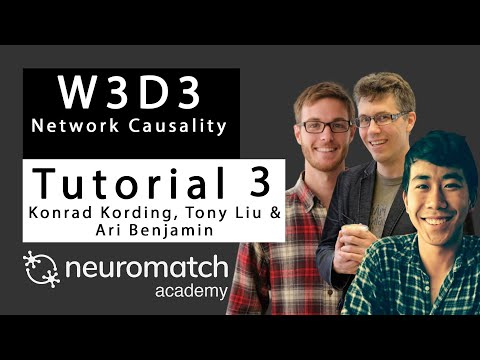

In [1]:
#@title Video 1: Regression approach
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Av4LaXZdgDo", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary of Video 1:
**Simultaneous fitting.**

- relation between correlation and fitting. 
- pairwise correlations are
dominated by network activity as the system becomes large.
But if we fit models, then these models can help us get rid of network induced correlations.
- we try to fit the data with implicit assumption of 
unconfoundedness; in the way it
assumes that all variables that could possibly matter, that are part of the dynamical system, a
part of the system that we do fit. If we don't have unconfoundedness,
we will have problems.

You may be familiar with the idea that correlation only implies causation when there no hidden *confounders*. This aligns with our intuition that correlation only implies causality when no alternative variables could explain away a correlation.

**A confounding example**:
Suppose you observe that people who sleep more do better in school. It's a nice correlation. But what else could explain it? Maybe people who sleep more are richer, don't work a second job, and have time to actually do homework. If you want to ask if sleep *causes* better grades, and want to answer that with correlations, you have to control for all possible confounds.

A confound is any variable that affects both the outcome and your original covariate. In our example, confounds are things that affect both sleep and grades. 

**Controlling for a confound**: 
Confonds can be controlled for by adding them as covariates in a regression. But for your coefficients to be causal effects, you need three things:
 
1.   **All** confounds are included as covariates
2.   Your regression assumes the same mathematical form of how covariates relate to outcomes (linear, GLM, etc.)
3.   No covariates are caused *by* both the treatment (original variable) and the outcome. These are [colliders](https://en.wikipedia.org/wiki/Collider_(statistics)); we won't introduce it today (but Google it on your own time! Colliders are very counterintuitive.)

In the real world it is very hard to guarantee these conditions are met. In the brain it's even harder (as we can't measure all neurons). Luckily today we simulated the system ourselves.

Video available at https://youtu.be/GvMj9hRv5Ak


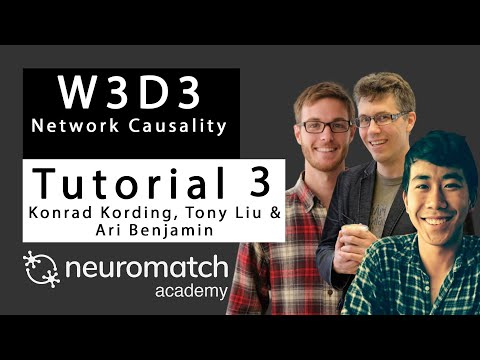

In [2]:
#@title Video 2: Fitting a GLM
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="GvMj9hRv5Ak", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary of Video 2:

**generalized linear model.**
- We are fitting a function x(t plus 1) is Sigmoid(Axt plus epsilon t).
This is the standard form for a generalized linear model. And in this case,
non-linearity is the Sigmoid here. 
- We'll bias the solution of that fitting to small weights,
the reason for that, is that it makes
overfitting be less pragmatic and if when for high dimensional spaces;

## Section 1.1: Recovering connectivity by model fitting

Recall that in our system each neuron effects every other via:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t), 
$$

where $\sigma$ is our sigmoid nonlinearity from before: $\sigma(x) = \frac{1}{1 + e^{-x}}$

Our system is a closed system, too, so there are no omitted variables. The regression coefficients should be the causal effect. Are they?

We will use a regression approach to estimate the causal influence of all neurons to neuron #1. Specifically, we will use linear regression to determine the $A$ in:

$$
\sigma^{-1}(\vec{x}_{t+1}) = A\vec{x}_t + \epsilon_t ,
$$

where $\sigma^{-1}$ is the inverse sigmoid transformation, also sometimes referred to as the **logit** transformation: $\sigma^{-1}(x) = \log(\frac{x}{1-x})$.

Let $W$ be the $\vec{x}_t$ values, up to the second-to-last timestep $T-1$:

$$
W = 
\begin{bmatrix}
\mid & \mid & ... & \mid \\ 
\vec{x}_0  & \vec{x}_1  & ... & \vec{x}_{T-1}  \\ 
\mid & \mid & ... & \mid
\end{bmatrix}_{n \times (T-1)}
$$

Let $Y$ be the $\vec{x}_{t+1}$ values for a selected neuron, indexed by $i$, starting from the second timestep up to the last timestep $T$:

$$
Y = 
\begin{bmatrix}
x_{i,1}  & x_{i,2}  & ... & x_{i, T}  \\ 
\end{bmatrix}_{1 \times (T-1)}
$$

You will then fit the following model:

$$
\sigma^{-1}(Y^T) = W^TV
$$

where $V$ is the $n \times 1$ coefficient matrix of this regression, which will be the estimated connectivity matrix between the selected neuron and the rest of the neurons.

**Review**: As you learned Friday of Week 1, *lasso* a.k.a. **$L_1$ regularization** causes the coefficients to be sparse, containing mostly zeros. Think about why we want this here.

*Hints*:

1. Why do we want regularisation at all?

2. When do we use L1 regularisation over L2?

*Answers*:

1. Without regularisation, the system could possibly overfit. 
2. The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.

## Exercise 1: Use linear regression plus lasso to estimate causal connectivities

You will now create a function to fit the above regression model and V. We will then call this function to examine how close the regression vs the correlation is to true causality.

**Code**:

You'll notice that we've transposed both $Y$ and $W$ here and in the code we've already provided below. Why is that? 

This is because the machine learning models provided in scikit-learn expect the *rows* of the input data to be the observations, while the *columns* are the variables. We have that inverted in our definitions of $Y$ and $W$, with the timesteps of our system (the observations) as the columns. So we transpose both matrices to make the matrix orientation correct for scikit-learn.


- Because of the abstraction provided by scikit-learn, fitting this regression will just be a call to initialize the `Lasso()` estimator and a call to the `fit()` function
- Use the following hyperparameters for the `Lasso` estimator:
    - `alpha = 0.01`
    - `fit_intercept = False`
- How do we obtain $V$ from the fitted model?


In [ ]:
def get_regression_estimate(X, neuron_idx):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int):  a neuron index to compute connectivity for

    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[[neuron_idx], 1:].transpose()

    # Apply inverse sigmoid transformation
    Y = logit(Y)

    ############################################################################
    ## TODO: Insert your code here to fit a regressor with Lasso. Lasso captures
    ## our assumption that most connections are precisely 0.
    ## Fill in function and remove
    raise NotImplementedError("Please complete the regression exercise")
    ############################################################################

    # Initialize regression model with no intercept and alpha=0.01
    regression = ...

    # Fit regression to the data
    regression.fit(...)

    V = regression.coef_

    return V

# Parameters
n_neurons = 50  # the size of our system
timesteps = 10000  # the number of timesteps to take
random_state = 42
neuron_idx = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)


# Uncomment below to test your function
# V = get_regression_estimate(X, neuron_idx)

#print("Regression: correlation of estimated connectivity with true connectivity: {:.3f}".format(np.corrcoef(A[neuron_idx, :], V)[1, 0]))

#print("Lagged correlation of estimated connectivity with true connectivity: {:.3f}".format(get_sys_corr(n_neurons, timesteps, random_state, neuron_idx=neuron_idx)))

In [ ]:
# to_remove solution
def get_regression_estimate(X, neuron_idx):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int):  a neuron index to compute connectivity for

    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[[neuron_idx], 1:].transpose()

    # Apply inverse sigmoid transformation
    Y = logit(Y)

    # Initialize regression model with no intercept and alpha=0.01
    regression = Lasso(fit_intercept=False, alpha=0.01)

    # Fit regression to the data
    regression.fit(W, Y)

    V = regression.coef_

    return V

# Parameters
n_neurons = 50  # the size of our system
timesteps = 10000  # the number of timesteps to take
random_state = 42
neuron_idx = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)


# Uncomment below to test your function
V = get_regression_estimate(X, neuron_idx)

print("Regression: correlation of estimated connectivity with true connectivity: {:.3f}".format(np.corrcoef(A[neuron_idx, :], V)[1, 0]))

print("Lagged correlation of estimated connectivity with true connectivity: {:.3f}".format(get_sys_corr(n_neurons, timesteps, random_state, neuron_idx=neuron_idx)))

You should find that using regression, our estimated connectivity matrix has a correlation of 0.865 with the true connectivity matrix. With correlation, our estimated connectivity matrix has a correlation of 0.703 with the true connectivity matrix.

We can see from these numbers that multiple regression is better than simple correlation for estimating connectivity.

---
# Section 2: Omitted Variable Bias

If we are unable to observe the entire system, **omitted variable bias** becomes a problem. If we don't have access to all the neurons, and therefore can't control them, can we still estimate the causal effect accurately?



## Section 2.1: Visualizing subsets of the connectivity matrix

We first visualize different subsets of the connectivity matrix when we observe 75% of the neurons vs 25%.

Recall the meaning of entries in our connectivity matrix: $A[i,j] = 1$ means a connectivity **from** neuron $i$ **to** neuron $j$ with strength $1$.


In [ ]:
#@markdown Execute this cell to visualize subsets of connectivity matrix

# Run this cell to visualize the subsets of variables we observe
n_neurons = 25
A = create_connectivity(n_neurons)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ratio_observed = [0.75, 0.25]  # the proportion of neurons observed in our system

for i, ratio in enumerate(ratio_observed):
    sel_idx = int(n_neurons * ratio)

    offset = np.zeros((n_neurons, n_neurons))
    axs[i,1].title.set_text("{}% neurons observed".format(int(ratio * 100)))
    offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
    im = axs[i, 1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
    axs[i, 1].set_xlabel("Connectivity from")
    axs[i, 1].set_ylabel("Connectivity to")
    plt.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)
    see_neurons(A,axs[i, 0],ratio)

plt.suptitle("Visualizing subsets of the connectivity matrix", y = 1.05)
plt.show()

## Section 2.2: Effects of partial observability

Video available at https://youtu.be/5CCib6CTMac


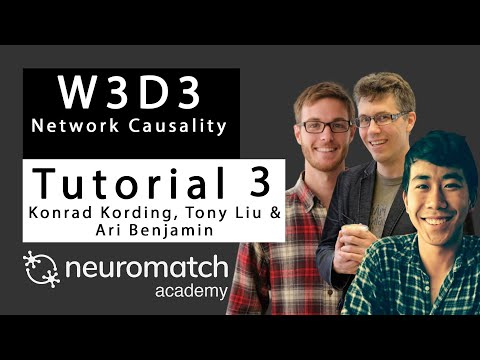

In [3]:
#@title Video 3: Omitted variable bias
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="5CCib6CTMac", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

**Video correction**: the labels "connectivity from"/"connectivity to" are swapped in the video but fixed in the figures/demos below

# Summary of Video 3:

-  Regression helps because it can effectively explain
a way some of the noise that is being induced
by all the different channels.
- In neuroscience, we almost
always only record a tiny subset
of neurons 
Or alternatively, we might
record
low-dimensional projections of the signals.
- In those cases, we have partially observed systems.
- And the system might act
differently. So, in this case, the system is confounded.
There exists
neurons that are not recorded,
that affect what the system does. These neurons are simply not observed.
They're still there. They're still producing activity.
And importantly, each of these neurons,
can now affect
multiple neurons in the pool of neurons that we have observed.
So,
explore
the proportion of observed neurons affect
the quality of our reconstructions 

### Interactive Demo: Regression performance as a function of the number of observed neurons

We will first change the number of observed neurons in the network and inspect the resulting estimates of connectivity in this interactive demo. How does the estimated connectivity differ?

**Note:** the plots will take a moment or so to update after moving the slider.

In [ ]:
#@markdown Execute this cell to enable demo
n_neurons = 50
A = create_connectivity(n_neurons, random_state=42)
X = simulate_neurons(A, 4000, random_state=42)

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

@widgets.interact
def plot_observed(n_observed=(5, 45, 5)):
  to_neuron = 0
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  sel_idx = n_observed
  ratio = (n_observed) / n_neurons
  offset = np.zeros((n_neurons, n_neurons))
  axs[0].title.set_text("{}% neurons observed".format(int(ratio * 100)))
  offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
  im = axs[1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

  see_neurons(A,axs[0], ratio, False)
  corr, R =  get_regression_corr_full_connectivity(n_neurons,
                                  A,
                                  X,
                                  ratio,
                                  reg_args)

  #rect = patches.Rectangle((-.5,to_neuron-.5),n_observed,1,linewidth=2,edgecolor='k',facecolor='none')
  #axs[1].add_patch(rect)
  big_R = np.zeros(A.shape)
  big_R[:sel_idx, :sel_idx] =  1 + R
  #big_R[to_neuron, :sel_idx] =  1 + R
  im = axs[2].imshow(big_R, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)
  c = 'w' if n_observed<(n_neurons-3) else 'k'
  axs[2].text(0,n_observed+3,"Correlation : {:.2f}".format(corr), color=c, size=15)
  #axs[2].axis("off")
  axs[1].title.set_text("True connectivity")
  axs[1].set_xlabel("Connectivity from")
  axs[1].set_ylabel("Connectivity to")

  axs[2].title.set_text("Estimated connectivity")
  axs[2].set_xlabel("Connectivity from")
  #axs[2].set_ylabel("Connectivity to")

Next, we will inspect a plot of the correlation between true and estimated connectivity matrices vs the percent of neurons observed over multiple trials.
What is the relationship that you see between performance and the number of neurons observed?

**Note:** the cell below will take about 25-30 seconds to run.


In [ ]:
#@title
#@markdown Plot correlation vs. subsampling
import warnings
warnings.filterwarnings('ignore')

# we'll simulate many systems for various ratios of observed neurons
n_neurons = 50
timesteps = 5000
ratio_observed = [1, 0.75, 0.5, .25, .12]  # the proportion of neurons observed in our system
n_trials = 3  # run it this many times to get variability in our results

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

corr_data = np.zeros((n_trials, len(ratio_observed)))
for trial in range(n_trials):

  A = create_connectivity(n_neurons, random_state=trial)
  X = simulate_neurons(A, timesteps)
  print("simulating trial {} of {}".format(trial + 1, n_trials))


  for j, ratio in enumerate(ratio_observed):
      result,_ = get_regression_corr_full_connectivity(n_neurons,
                                    A,
                                    X,
                                    ratio,
                                    reg_args)
      corr_data[trial, j] = result

corr_mean = np.nanmean(corr_data, axis=0)
corr_std = np.nanstd(corr_data, axis=0)

plt.plot(np.asarray(ratio_observed) * 100, corr_mean)
plt.fill_between(np.asarray(ratio_observed) * 100,
                    corr_mean - corr_std,
                    corr_mean + corr_std,
                    alpha=.2)
plt.xlim([100, 10])
plt.xlabel("Percent of neurons observed")
plt.ylabel("connectivity matrices correlation")
plt.title("Performance of regression as a function of the number of neurons observed");

---
# Summary


Video available at https://youtu.be/T1uGf1H31wE


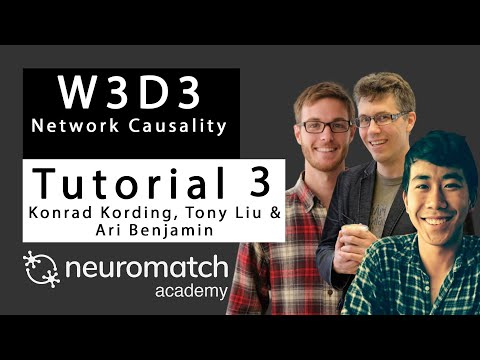

In [4]:
#@title Video 4: Summary
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="T1uGf1H31wE", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary of Video 4:

-  partial observability
is really bad. As the ratio of variables
observed approaches zero, we ultimately stop being able to fit anything meaningfully.
Now, this is because there's a clear violation of unconfoundedness.
- We will typically record from hundreds or thousands of neurons.
In fMRI research, we will, if we are lucky, record from tens of thousands of voxels.
The brain is 10 to the 11
dimensional. 
So, partial observability, when doing such fitting methods, is something that we should be very worried about.
Now, that is because there's the unobserved variable bias. For linear system,
we can exactly understand these biases. They're impossible to get rid of
because of unconfoundedness and for most systems, there is no solution to the problem.
- In partially observed systems, model fitting
fails to meaningfully reveal causality. And as the ratio of observed dimensions gets to be very large,
we get to be very very bad at estimating causality. The problem is bias introduced by unobserved variables.
It's generally impossible to distinguish signals made by unobserved variables from true causal effects.
There's an analysis principle here. Us neuroscientists, should not claim causal inference for systems,
if the methods that we require have to assume unconfoundedness. We cannot have unconfoundedness
and that's why in most systems, we cannot have causality unless we perturb the systems.


In this tutorial, we explored:

1) Using regression for estimating causality

2) The problem of omitted variable bias, and how it arises in practice